# Spotify Song Prediction

##### Dependencies

In [15]:
# Ucitavanje biblioteka i funkcija
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso


##### Loading the dataset

In [50]:
df = pd.read_csv('spotify_songs.csv')
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


##### Dropping invalid and missing values

In [51]:
columns_to_drop = ['track_id', 'track_name', 'track_album_id', 'track_album_name', 'playlist_name', 'playlist_id']
df.drop(columns=columns_to_drop, inplace=True)
df.dropna(axis=0, inplace=True)

rows_to_drop = df.loc[df['duration_ms'] < 20000].index
df.drop(rows_to_drop, inplace=True)

new_df = df.copy()

# Assuming 'date' is a string column in the format 'YYYY-MM-DD'
new_df[['year', 'month', 'day']] = new_df['track_album_release_date'].str.split('-', expand=True)

# Convert the columns to numeric (to handle missing values during median calculation)
new_df['year'] = pd.to_numeric(new_df['year'], errors='coerce', downcast='integer')
new_df['month'] = pd.to_numeric(new_df['month'], errors='coerce', downcast='integer')
new_df['day'] = pd.to_numeric(new_df['day'], errors='coerce', downcast='integer')

# Calculate median values for year, month, and day
median_year = int(new_df['year'].median())
median_month = int(new_df['month'].median())
median_day = int(new_df['day'].median())

# Fill missing values with median values
new_df['year'] = new_df['year'].fillna(median_year).astype(int)
new_df['month'] = new_df['month'].fillna(median_month).astype(int)
new_df['day'] = new_df['day'].fillna(median_day).astype(int)

x = new_df.drop(['track_popularity'], axis=1)
y = new_df['track_popularity']


In [52]:
x.head()

,track_artist,track_album_release_date,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year,month,day
0,Ed Sheeran,2019-06-14,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754,2019,6,14
1,Maroon 5,2019-12-13,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600,2019,12,13
2,Zara Larsson,2019-07-05,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616,2019,7,5
3,The Chainsmokers,2019-07-19,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093,2019,7,19
4,Lewis Capaldi,2019-03-05,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052,2019,3,5


In [55]:
df.iloc[3446]
x.iloc[3446]

track_artist                 Soft Cell
track_album_release_date       1981-12
playlist_genre                     pop
playlist_subgenre           electropop
danceability                      0.63
energy                           0.526
key                                  7
loudness                        -9.121
mode                                 1
speechiness                     0.0389
acousticness                     0.316
instrumentalness               0.00538
liveness                        0.0747
valence                           0.61
tempo                          145.271
duration_ms                     215333
year                              1981
month                               12
day                                 14
Name: 3446, dtype: object

##### Splitting the dataset

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)

(array([0.03031042, 0.0065571 , 0.00565084, 0.0057803 , 0.00664087,
        0.00664087, 0.00782892, 0.00922259, 0.01179669, 0.01376915,
        0.01386054, 0.01449264, 0.01503336, 0.01510951, 0.01529229,
        0.01491912, 0.01367015, 0.01284004, 0.01031925, 0.00875042,
        0.00493496, 0.00321382, 0.00188869, 0.00093673, 0.00054071]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100.]),
 <BarContainer object of 25 artists>)

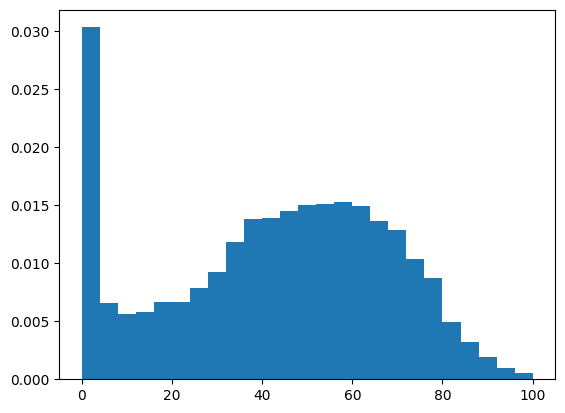

In [16]:
plt.hist(y, density=True, bins=25)

In [17]:
x.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32827.000000,32827.000000,32827.000000,32827.000000,32827.000000,32827.000000,32827.000000,32827.000000,32827.000000,32827.000000,32827.000000,32827.000000
mean,0.654870,0.698614,5.374082,-6.718939,0.565723,0.107057,0.175357,0.084762,0.190181,0.510571,120.887324,225803.586316
std,0.145049,0.180906,3.611546,2.986774,0.495669,0.101307,0.219646,0.224248,0.154312,0.233138,26.895767,59824.879597
min,0.077100,0.000175,0.000000,-46.448000,0.000000,0.022400,0.000001,0.000000,0.009360,0.000010,35.477000,29493.000000
25%,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.961000,187812.500000
50%,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918500,253582.500000
max,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


In [18]:
numerical_feats = ['danceability', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

print(x[numerical_feats])

       danceability  loudness  speechiness  acousticness  instrumentalness  \
0             0.748    -2.634       0.0583      0.102000          0.000000   
1             0.726    -4.969       0.0373      0.072400          0.004210   
2             0.675    -3.432       0.0742      0.079400          0.000023   
3             0.718    -3.778       0.1020      0.028700          0.000009   
4             0.650    -4.672       0.0359      0.080300          0.000000   
...             ...       ...          ...           ...               ...   
32828         0.428    -1.814       0.0936      0.076600          0.000000   
32829         0.522    -4.462       0.0420      0.001710          0.004270   
32830         0.529    -4.899       0.0481      0.108000          0.000001   
32831         0.626    -3.361       0.1090      0.007920          0.127000   
32832         0.603    -4.571       0.0385      0.000133          0.341000   

       liveness  valence    tempo  duration_ms  
0        0.065